In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from gnuradio import channels, gr, blocks, analog, digital
import datetime as dt
import sigmf
from sigmf import SigMFFile, sigmffile, utils
from signals.waveform import *
from tqdm.notebook import tqdm

 ## Data Processing Parameters

In [2]:
# Number of vectors per modulation class
nVecClass = 500
# Number of samples per class vector
nSampsVec = 128
# Loop through all the waveform types defined in this list
np.random.seed(0)
waveforms = [LinearFMWaveform, SquareWaveform, bpsk, qpsk, qam(16)]
# Noise voltages to simulate
noiseVoltages = [0,10**(-20/20),10**(-10/20),10**(10/20), 10**(20/20) ]
nClasses = len(waveforms)
nSampsTotal = nSampsVec*nVecClass*nClasses*len(noiseVoltages)
data = np.zeros((nSampsTotal,), dtype=np.complex64)
nSampsProduced = 0

 ## Global Variables

In [3]:
# Modulation parameters
sampRate = 20e6
# Metadata setup
dataDir = 'data/'
filename = 'dataset'
# Create directory if it doesn't exist
Path(dataDir).mkdir(parents=True, exist_ok=True)
# Open and close the data file to create it if it doesn't exist. This is
# necessary for the SigMFFile object below
datafile = open(dataDir+filename+'.sigmf-data', 'w+')
datafile.close()
meta = SigMFFile(
    data_file=dataDir+filename+'.sigmf-data',
    global_info={
        SigMFFile.DATATYPE_KEY: 'cf32_le',
        SigMFFile.SAMPLE_RATE_KEY: sampRate,
        SigMFFile.AUTHOR_KEY: 'Shane Flandermeyer, shane.flandermeyer@ou.edu',
        SigMFFile.DESCRIPTION_KEY: 'Synthetic RF dataset for machine learning',
        SigMFFile.VERSION_KEY: sigmf.__version__,
    }
)
# Channel parameters
# Maximum doppler frequency used in channel fading simulation
doppFreq = 1
# Fractional sample delays in the power delay profile
delays = [0.0, 0.9, 1.3]
# Magnitudes corresponding to the delays above
mags = [1, 0.99, 0.97]
# Length of the filter to interpolate the power delay profile over
nTaps = 8
# Waveform parameters
minBandwidth = 1e6
maxBandwidth = 100e6
minPulsewidth = 1e-6
maxPulsewidth = 100e-6
bandwidth = minBandwidth + \
    np.random.rand(nVecClass)*(maxBandwidth-minBandwidth)
pulsewidth = minPulsewidth + \
    np.random.rand(nVecClass)*(maxPulsewidth-minPulsewidth)

## I/Q Diagrams for each waveform

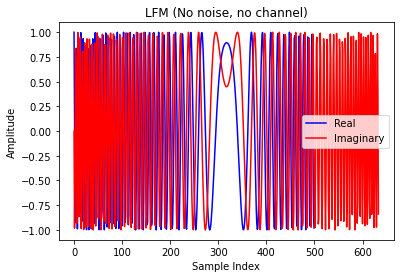

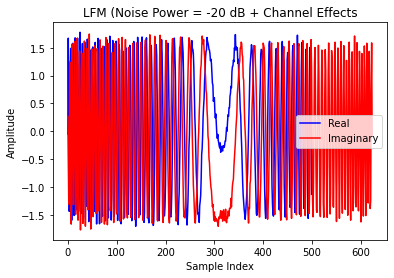

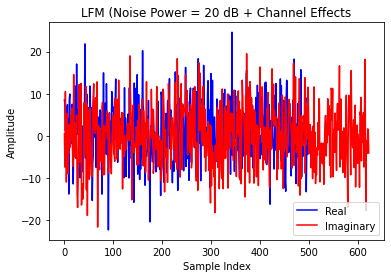

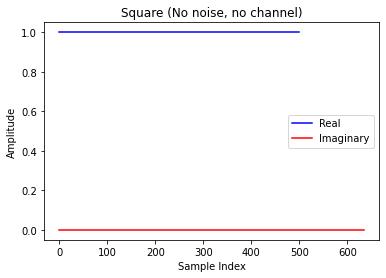

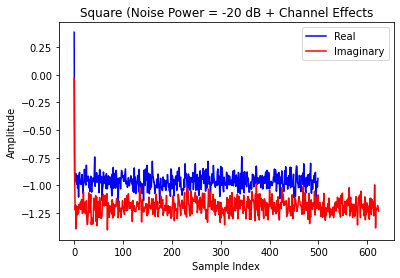

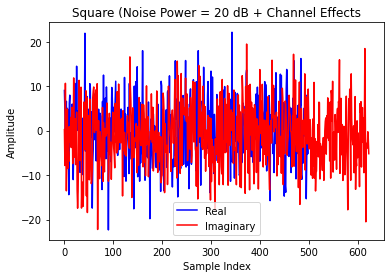

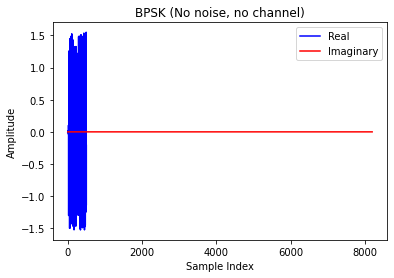

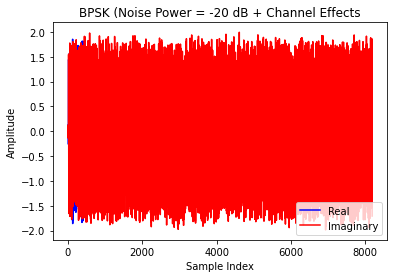

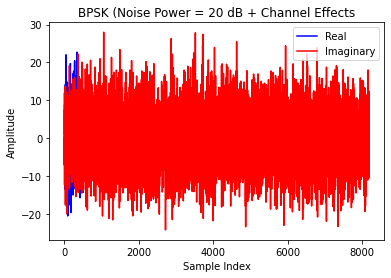

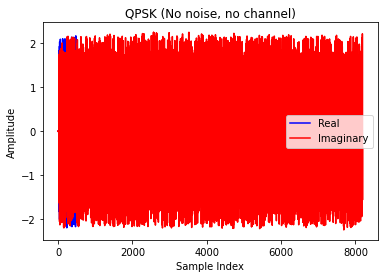

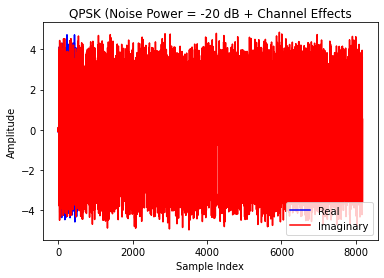

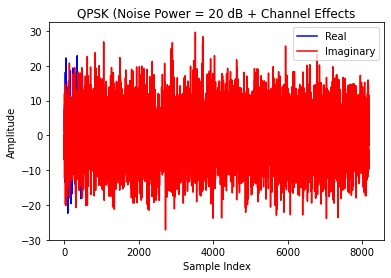

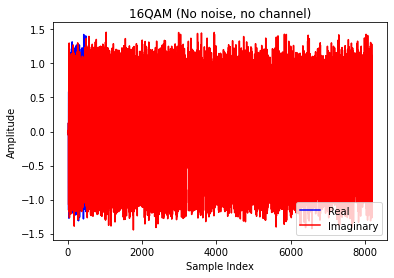

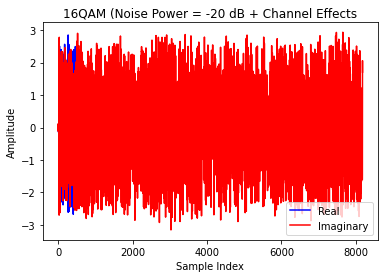

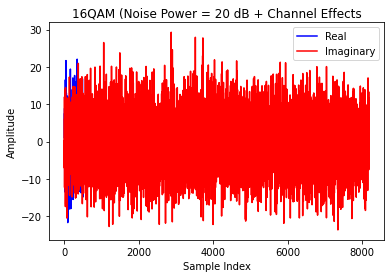

In [12]:
testVoltages = [0,10**(-20/20),10**(20/20)]
for wave in waveforms:
    # Create signal object and associated transmitter
    if callable(wave):
        sig = wave(bandwidth=bandwidth[0],
                   pulsewidth=pulsewidth[0], sampRate=sampRate)
    else:
        sig = wave
    for voltage in testVoltages:
        tb = gr.top_block()
        tx = sig.transmitter(repeat=False)
        channel = channels.dynamic_channel_model(
            sampRate, 0.01, 50, .01, 0.5e3, 8, doppFreq, True, 4, delays, mags, nTaps, voltage, 0x1337)
        sink = blocks.vector_sink_c()
        if voltage != 0:
            tb.connect(tx,channel,sink)
        else:
            tb.connect(tx,sink)
        tb.run()
        plt.plot(np.real(sink.data()[0:500]),'b')
        plt.plot(np.imag(sink.data()[0:500]),'r')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.legend(['Real', 'Imaginary'])
        if voltage != 0:
            voltage_db = int(20*np.log10(voltage))
            plt.title(sig.label + f' (Noise Power = {voltage_db} dB + Channel Effects')
            plt.savefig('figures/' + sig.label + f'_{voltage_db}dB' + '.png')
        else:
            plt.title(sig.label + ' (No noise, no channel)')
            plt.savefig('figures/' + sig.label + '.png')
        plt.show()
    

 ## Main Simulation Loop

In [5]:
for voltage in noiseVoltages:
    # noiseAmplitude = 10**(voltage/20)
    voltage_db = 20*np.log10(voltage)
    channel = channels.dynamic_channel_model(
        sampRate, 0.01, 50, .01, 0.5e3, 8, doppFreq, True, 4, delays, mags, nTaps, voltage, 0x1337)
    print(f'Simulating SNR = {voltage_db} dB')
    for wave in tqdm(waveforms):
        # Flowgraph
        tb = gr.top_block()
        # Create signal object and associated transmitter
        if callable(wave):
            sig = wave(bandwidth=bandwidth[0],
                       pulsewidth=pulsewidth[0], sampRate=sampRate)
        else:
            sig = wave
        tx = sig.transmitter(repeat=False)
        sink = blocks.vector_sink_c()
        # Create the flowgraph
        tb.connect(tx, channel, sink)
        # Generate nVecClass vectors of nSampsVec samples each
        for iVec in range(nVecClass):
            if isinstance(sig, RadarWaveform):
                # Create signal object and associated transmitter
                sig.bandwidth = bandwidth[iVec]
                sig.pulsewidth = pulsewidth[iVec]
                tx.set_data(sig.sample())
            # Run the simulation
            tb.run()
            # Choose a random subset of the data to add to the dataset. This ensures
            # that the model will get a broader variety of signals than if we saved
            # a fixed part of each signal
            startIdx = np.random.randint(0, len(sink.data())-nSampsVec)
            result = np.array(
                sink.data()[startIdx:startIdx+nSampsVec], dtype=np.complex64)
            # Save off the data and corresponding metadata
            detail = sig.detail
            sig.detail.noise_voltage = str(voltage_db)
            metaDict = {
                SigMFFile.LABEL_KEY: sig.label,
                SigMFFile.DATETIME_KEY: dt.datetime.utcnow().isoformat()+'Z'}
            metaDict[sig.DETAIL_KEY] = detail.dict()
            meta.add_annotation(nSampsProduced, len(result), metadata=metaDict)
            # Normalize the energy to stay consistent with different modulations
            energy = np.sum(np.abs(result)**2)
            data[nSampsProduced:nSampsProduced +
                 nSampsVec] = result/np.sqrt(energy)
            nSampsProduced += nSampsVec

# Check for mistakes and write to file
data.tofile(dataDir+filename+'.sigmf-data')
assert meta.validate()
# Write metadata to file
meta.tofile(dataDir+filename)

Simulating SNR = -inf dB


/tmp/ipykernel_136066/1181600932.py:3: RuntimeWarning: divide by zero encountered in log10
  voltage_db = 20*np.log10(voltage)


  0%|          | 0/5 [00:00<?, ?it/s]

Simulating SNR = -20.0 dB


  0%|          | 0/5 [00:00<?, ?it/s]

Simulating SNR = -10.0 dB


  0%|          | 0/5 [00:00<?, ?it/s]

Simulating SNR = 10.0 dB


  0%|          | 0/5 [00:00<?, ?it/s]

Simulating SNR = 20.0 dB


  0%|          | 0/5 [00:00<?, ?it/s]